In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import psycopg2 as pg2

from sqlalchemy import create_engine

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# Set db variables
user = 'anthony'
pw = 'pw'
host = 'localhost:5432'
db_name = 'indicator_tests'

# Create engine for interacting with db
engine = create_engine(f'postgresql+psycopg2://{user}:{pw}@{host}/{db_name}')

### Get NASDAQ ETF list :


In [3]:
nas_etf = pd.read_csv('../data/NAS_ETF_List.csv')

In [7]:
nas_etf = nas_etf['Symbol'].to_list()

In [19]:
nas_etf[:10]

['IJH', 'IJJ', 'IJK', 'IJR', 'IJS', 'IJT', 'IMFP', 'INAU', 'ISMD', 'ITA']

### SMA Entries

In [21]:
sma_nas = pd.read_sql_query(f'''SELECT ticker, sma_win
                                FROM sma_nasdaq
                                WHERE sma_buy = 1''',
                            con=engine)

In [22]:
# Note: some tickers are None
sma_nas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3043 entries, 0 to 3042
Data columns (total 2 columns):
ticker     3035 non-null object
sma_win    3043 non-null int64
dtypes: int64(1), object(1)
memory usage: 47.7+ KB


In [23]:
sma_nas.dropna(inplace=True)

In [24]:
sma_nas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3035 entries, 0 to 3042
Data columns (total 2 columns):
ticker     3035 non-null object
sma_win    3035 non-null int64
dtypes: int64(1), object(1)
memory usage: 71.1+ KB


In [25]:
# Remove ETFs if exist
sma_nas = sma_nas[~sma_nas.ticker.isin(nas_etf)]

In [26]:
sma_nas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2976 entries, 0 to 3042
Data columns (total 2 columns):
ticker     2976 non-null object
sma_win    2976 non-null int64
dtypes: int64(1), object(1)
memory usage: 69.8+ KB


In [27]:
sma_nas.head()

,ticker,sma_win
0,MVIS,0
1,MVIS,0
2,MVIS,1
3,MVIS,1
4,MVIS,0


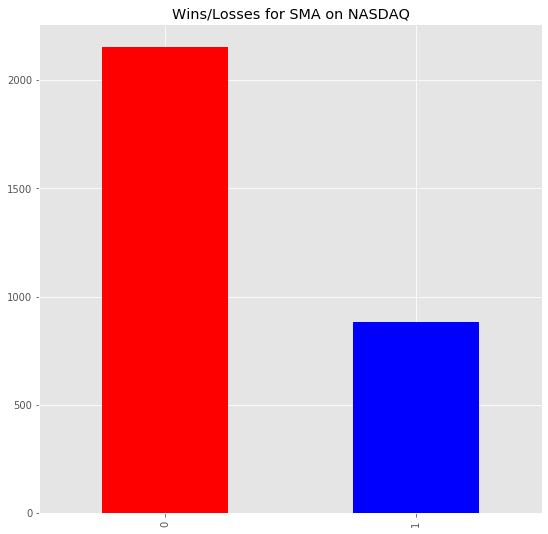

In [8]:
ax = sma_nas.sma_win.value_counts().plot(kind='bar',
                                         figsize=(9,9),
                                         title= 'Wins/Losses for SMA on NASDAQ',
                                         color=['red', 'blue']
                                        )

In [9]:
wins = sma_nas.sma_win.value_counts()[1]
losses = sma_nas.sma_win.value_counts()[0]
sma_mean = sma_nas.loc[:,"sma_win"].mean()
std = sma_nas.loc[:,"sma_win"].std()
sma_se = std / np.sqrt(wins+losses)
print(f'wins: {wins}\nlosses: {losses}\nmean: {sma_mean}\nstd: {std}\nse: {sma_se}')

wins: 884
losses: 2151
mean: 0.2912685337726524
std: 0.4544218461808592
se: 0.00824859259696956


Text(0, 0.5, 'Observations')

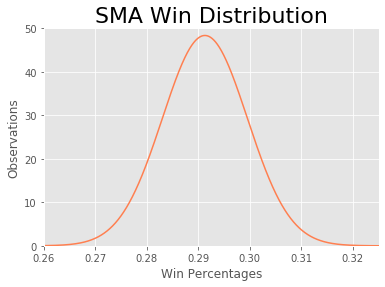

In [22]:
x_min = 0.26
x_max = 0.325

mean = sma_mean 
std = sma_se

x = np.linspace(x_min, x_max, wins+losses)

y = sts.norm.pdf(x,mean,std)

plt.plot(x,y, color='coral')

plt.xlim(x_min,x_max)
plt.ylim(0,50)

plt.title('SMA Win Distribution',fontsize=22)

plt.xlabel('Win Percentages')
plt.ylabel('Observations')

### Random Entries

In [23]:
rnd_nas = pd.read_sql_query(f'''SELECT ticker, rnd_win
                                FROM sma_nasdaq
                                WHERE rnd_buy = 1''',
                            con=engine)

In [24]:
rnd_nas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2986 entries, 0 to 2985
Data columns (total 2 columns):
ticker     2986 non-null object
rnd_win    2986 non-null int64
dtypes: int64(1), object(1)
memory usage: 46.8+ KB


In [25]:
rnd_nas.head()

,ticker,rnd_win
0,MVIS,0
1,MVIS,1
2,MVIS,1
3,MVIS,0
4,MVIS,0


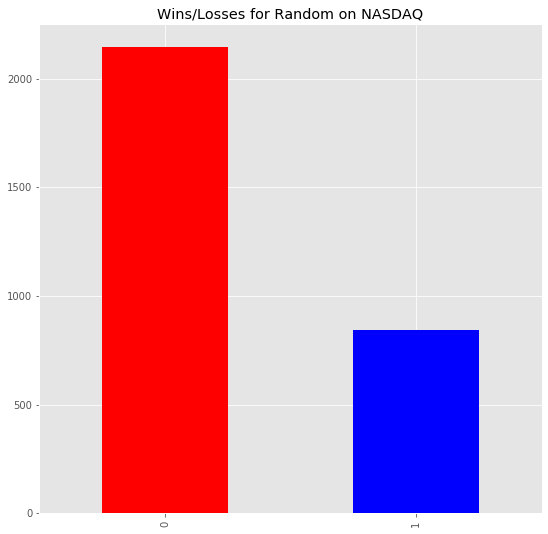

In [26]:
ax = rnd_nas.rnd_win.value_counts().plot(kind='bar',
                                         figsize=(9,9),
                                         title= 'Wins/Losses for Random on NASDAQ',
                                         color=['red', 'blue']
                                        )

In [27]:
wins = rnd_nas.rnd_win.value_counts()[1]
losses = rnd_nas.rnd_win.value_counts()[0]
rnd_mean = rnd_nas.loc[:,"rnd_win"].mean()
std = rnd_nas.loc[:,"rnd_win"].std()
rnd_se = std / np.sqrt(wins+losses)
print(f'wins: {wins}\nlosses: {losses}\nmean: {rnd_mean}\nstd: {std}\nse: {rnd_se}')

wins: 843
losses: 2143
mean: 0.28231748158070996
std: 0.45020239744938706
se: 0.008238779917613369


Text(0, 0.5, 'Observations')

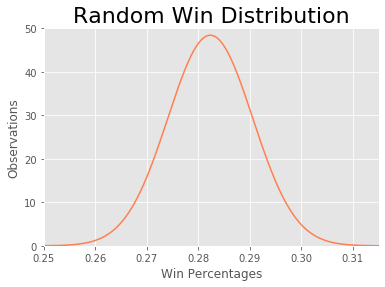

In [32]:
x_min = 0.25
x_max = 0.315

mean = rnd_mean 
std = rnd_se

x = np.linspace(x_min, x_max, wins+losses)

y = sts.norm.pdf(x,mean,std)

plt.plot(x,y, color='coral')

plt.xlim(x_min,x_max)
plt.ylim(0,50)

plt.title('Random Win Distribution',fontsize=22)

plt.xlabel('Win Percentages')
plt.ylabel('Observations')

# Calculate Statistics

In [28]:
rnd_data = rnd_nas.rnd_win
sma_data = sma_nas.sma_win

t_stat, p_value = sts.ttest_ind(rnd_data, sma_data, equal_var=False)

print(f't_stat: {t_stat}\np_value: {p_value}')

t_stat: -0.7677813523155645
p_value: 0.44264721467983303
